In [1]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt 

import random

import platform_opt
from players import *

In [5]:
# SIMULATION PARAMETERS
T = 8                 # max number of timesteps
PI = {1: 0.43294, 
     -1: 0.56706}          # number of members in groups a and b #estimated from probability_sharing_distributions.ipynb
PI_A = PI[1]

M = 100000              # size of unit mass


# probability of like | click, user group, article group
# P indexed (article group, user group). 
#estimated from probability_sharing_distributions.ipynb
P = {( 1,  1):  0.0692, 
     ( -1, 1):  0.001815,
     (1,  -1):  0.003995,
     (-1, -1):  0.08344} 

BETA = {(1,1) : (0.8828729918440646, 1.6247070146941363),
        (-1,1) : (0.1822515775580026, 2.7574965182522644),
        (1,-1) : (0.09576097403924465, 3.09136619146736),
        (-1,-1): (0.9541492709534125, 1.345006644515015)}

# utility for liking, known to both user and platform,
# v indexed by (article shown, user group) pair
#unclear what these values should be!
V = {( 1,  1):   2000.,
     (-1,  1):   100.,
     ( 1, -1):   100.,
     (-1, -1):   2000. }

# cost of clicking, known to both user and platform,
# c indexed by (article shown, user group)
C = {( 1,  1):   1.,
     (-1,  1):   1.,
     ( 1, -1):   1.,
     (-1, -1):   1. }

# transition probability across groups at time t + 1 
# indexed by the first user's group membership
Q = {1:  0.6798, 
     -1: 0.7193}

# approximation parameter for approximately equal probability
EPSILON = 0.2  

# platform chooses their probability for showing article a by maximizing
# expected clickthrough rate subject to fairness constraints
# probshowA = platform_opt.optimize(epsilon, M * pi_a, M, T,
#                                   P[('1', '1')], P[('-1', '1')],
#                                   PLA=problike[1], PLB=problike[-1],
#                                   muA = probclick[1], muB=probclick[-1])


# display policy from platform
# indexed by user group, since this is implicitly the probability of show a user article a
# theta_hat = {1:1., -1:0.}

THETA_HAT = platform_opt.opt(PI, Q, T, EPSILON, C, V, BETA)
print(THETA_HAT)
#print(platform_opt.psi(c,v,beta_dist))

{1: 0.14091215413745678, -1: 1.0}


In [8]:
def simulate(T=8, pi_a=PI_A, Ps=P, beta_dist=BETA, v=V, c=C, q=Q, epsilon=EPSILON, theta_hat=THETA_HAT):
    old_u = []
    time_data_diff = []
    num_players_in_model = [M]
    prob_article_A = []
    prob_article_A_cum = []
    tot_shown_A = 0
    tot_in_model = 0
    t = 1
    while (t <= T) and (t == 1 or len(old_u) > 0):
        num_shown_A = 0 #number of players at this timestep that are shown article A
        new_u = []  # list of new players that arrive at the timestep

        if t == 1:  # initial mass of users arrives
            for i in range(M): # iterating over the size of the unit mass
                tot_in_model = tot_in_model + 1
                g = coin_toss(pi_a) # determine players group according to the true group distribution
                a = coin_toss(theta_hat[g]) # show article A according to the platform's policy.  (right now, this is just a placeholder)
                player = Player(group=g, article=a)
                if a == 1:
                    num_shown_A = num_shown_A + 1
                    player.article = 1
                else:
                    player.article = -1

                P_personal = Ps
                P_personal[(a,g)] = np.random.beta(*beta_dist[(a,g)])
                P_personal[(-a,g)] = np.random.beta(*beta_dist[(-a,g)])

                player.clicked = calcclickdict(player, 1, 
                                                  P_personal, 
                                                  q, 
                                                  theta_hat,
                                                  c,
                                                  v)
                if player.clicked:  
                        if random.uniform(0, 1) <= P[(player.article, player.group)]:
                            player.shared = True
                old_u.append(player)
            print("First time step: " + str(num_shown_A) + " users shown article A")

        else:
            for user in old_u:

                if user.shared == 1: # new user only added to the system if the previous user shared the article
                    tot_in_model = tot_in_model + 1
                    if random.uniform(0, 1) <= q[user.group]:  # if next person is drawn by homophily
                        new_user = Player(group=user.group)
                    else:
                        new_user = Player(group=-user.group)
                    new_user.article = user.article
                    if new_user.article == 1:
                        num_shown_A = num_shown_A + 1


                    P_personal = P
                    P_personal[(a,g)] = np.random.beta(*beta_dist[(new_user.article ,new_user.group)])
                    P_personal[(-a,g)] = np.random.beta(*beta_dist[(-a,g)])
                    new_user.clicked = calcclickdict(new_user, 1, 
                                                  P_personal, 
                                                  q, 
                                                  theta_hat,
                                                  c,
                                                  v)
                    # decide if user shares article, according to P.
                    if new_user.clicked == 1:  
                        if random.uniform(0, 1) <= P[(new_user.article, new_user.group)]:
                            new_user.shared = True
                    else:
                        new_user.shared = False

                    #add user to list
                    new_u.append(new_user)
                else: #only add a user to the next round if the previous user shared the article 
                    pass

            num_players_in_model.append(len(new_u)) #tracks how many players are being shown articles at all timesteps
            old_u = new_u

            # print("Number of players left: " + str(len(new_u))) #debugging statement


        t = t + 1
        tot_shown_A = tot_shown_A + num_shown_A
        if len(old_u) > 0:
            prob_article_A.append(num_shown_A / float(len(old_u)))
            prob_article_A_cum.append(tot_shown_A / float(tot_in_model))

    print(prob_article_A)
    print(num_players_in_model)
    print(prob_article_A_cum[-1])
    return prob_article_A, num_players_in_model, prob_article_A_cum, t
    
p_art_A, n_players, p_art_cum, t = simulate()

First time step: 62867 users shown article A
[0.62867, 0.6412251655629139, 0.8017184401850628, 0.8461538461538461, 0.8374384236453202, 0.8588235294117647, 0.9411764705882353, 0.9285714285714286]
[100000, 6040, 1513, 559, 203, 85, 34, 14]
0.6336124225435231


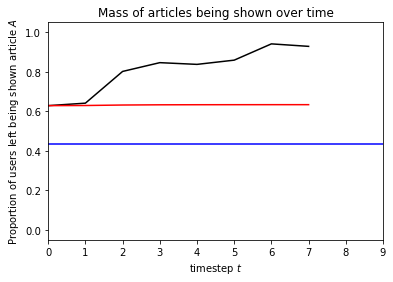

In [9]:
plt.plot(p_art_A, color='black')
plt.plot(p_art_cum, color='red')
plt.title("Mass of articles being shown over time")
plt.ylabel("Proportion of users left being shown article $A$")
plt.xlabel("timestep $t$")
plt.axhline(y=PI_A,color='blue')
plt.ylim((-0.05,1.05))
plt.xlim((0,t))
plt.show()

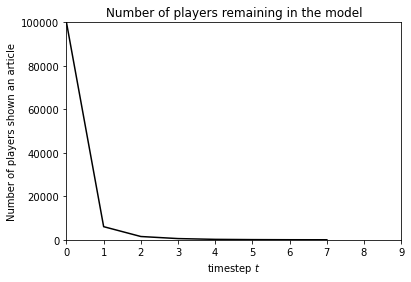

In [10]:
plt.plot(n_players, color='black')
plt.title("Number of players remaining in the model")
plt.ylabel("Number of players shown an article")
plt.xlabel("timestep $t$")
plt.xlim((0,t))
plt.ylim((0, M + 1))
plt.show()

In [14]:
import ipywidgets as widgets
from ipywidgets import interact

@interact(Pi_a=(0, 1.0))
def viz(Pi_a):
    theta = platform_opt.opt({1: Pi_a,  -1: 1 - Pi_a}, Q, T, EPSILON, C, V, BETA)
    p_art_A, n_players, p_art_cum, t = simulate(pi_a=Pi_a, theta_hat=theta)
    plt.plot(p_art_A, color='black')
    plt.plot(p_art_cum, color='red')
    plt.title("Mass of articles being shown over time")
    plt.ylabel("Proportion of users left being shown article $A$")
    plt.xlabel("timestep $t$")
    plt.axhline(y=Pi_a,color='blue')
    plt.ylim((-0.05,1.05))
    plt.xlim((0,t))
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='Pi_a', max=1.0), Output()), _dom_classes=('widget-in…

In [ ]:
'''
# out of date but afraid to erase 
plt.plot(time_data_diff, color='black')
plt.title("Mass of articles being shown over time")
plt.ylabel("learning towards article $a$ (1) and $b$ (-1)")
plt.xlabel("timestep t")
plt.ylim((-1,1))
plt.axhline(y=0,color='grey')
plt.axhline(y=np.average(time_data_diff),color='blue')
#plt.axhline(y=epsilon,color='red')
#plt.axhline(y=-1 * epsilon,color='red')
plt.show()
'''